## Predicting the most influential variables on whether or not a client will subscribe a term deposit

## Introduction:
The data set we are working on is the bank marketing data set. The bank we are analyzing is a Portuguese banking institution with data related with direct marketing campaigns (phone calls).

This dataset contains many variables as shown when we load the file below. However some of the more cryptic variables are defined here:

- `default` - Has credit in default?
- `balance` - Account balance (EUR)
- `housing` - Has housing loan?
- `contact` - Contact communication type
- `month` / `day_of_week` - Date of last contact
- `duration` - Last contact duration, in seconds
- `campaign` - Number of contacts performed during this campaign and for this client
- `pdays` - Number of days that passed by after the client was last contacted from a previous campaign
- `previous` - Number of contacts performed before this campaign and for this client 
- `poutcome` - Outcome of the previous marketing campaign
- `y` - Has the client subscribed a term deposit?

Using this dataset we will attempt to answer the question "Which variables have the greatest influence on predicting whether or not a client will subscribe a term deposit?" A term deposit is a cash investment held at a financial institution. Your money is invested for an agreed rate of interest over a fixed amount of time, or term.

Based on our existing knowledge of the space we believe that balance will be the greatest predictor.

## Method:

Throughout this project we explain step by step the method we use. In a short summary, we first obtain, clean, and mutate the data to make all the variables numeric to be able to properly use the KNN algorithm and create a correlation table. For the KNN algorithm We create models, specifications, and a best fit for each individual separately and we see which variable yields the highest accuracy as a predictor. We then back our evidence through different graphs to come up with our conclusion. After performing these steps on the data however we were still left with inconlusive results so we decided to do some research ourselves and use some algroithms we had not learned in class to find an answer to our question. For a more detailed description of our method, read along our step by step procedure.

First we load the libraries required to perform the data analysis. We also make sure to set the seed so that the results are repeatable and not affected by randomness.

In [30]:
set.seed(1337)

library(tidyverse)
library(repr)
library(rvest)
library(stringr)
library(tidymodels)
library(randomForest)

Next we download, extract, and parse our dataset from the web.

In [36]:
# download and extract dataset
dir.create("data/")
download.file("https://archive.ics.uci.edu/ml/machine-learning-databases/00222/bank.zip", destfile = "data/bank.zip")
unzip("data/bank.zip", files = "bank-full.csv", exdir = "data/", overwrite = TRUE)

# load dataset
bank_full <- read_delim("data/bank-full.csv", delim = ';')
slice(bank_full, 1:10)

Warning message in dir.create("data/"):
“'data' already exists”
Parsed with column specification:
cols(
  age = col_double(),
  job = col_character(),
  marital = col_character(),
  education = col_character(),
  default = col_character(),
  balance = col_double(),
  housing = col_character(),
  loan = col_character(),
  contact = col_character(),
  day = col_double(),
  month = col_character(),
  duration = col_double(),
  campaign = col_double(),
  pdays = col_double(),
  previous = col_double(),
  poutcome = col_character(),
  y = col_character()
)



age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no
35,management,married,tertiary,no,231,yes,no,unknown,5,may,139,1,-1,0,unknown,no
28,management,single,tertiary,no,447,yes,yes,unknown,5,may,217,1,-1,0,unknown,no
42,entrepreneur,divorced,tertiary,yes,2,yes,no,unknown,5,may,380,1,-1,0,unknown,no
58,retired,married,primary,no,121,yes,no,unknown,5,may,50,1,-1,0,unknown,no


We decide to filter out the columns we thought would not play any relationship to whether or not a client subscribed a term deposit or were very difficult to deal with using algorithm. We removed all columns related to date, method of communication, and whether they had defaulted. 

In [37]:
bank_trimmed <- bank_full %>%
    select(-c(default, contact, day, month))
slice(bank_trimmed, 1:10)

age,job,marital,education,balance,housing,loan,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
58,management,married,tertiary,2143,yes,no,261,1,-1,0,unknown,no
44,technician,single,secondary,29,yes,no,151,1,-1,0,unknown,no
33,entrepreneur,married,secondary,2,yes,yes,76,1,-1,0,unknown,no
47,blue-collar,married,unknown,1506,yes,no,92,1,-1,0,unknown,no
33,unknown,single,unknown,1,no,no,198,1,-1,0,unknown,no
35,management,married,tertiary,231,yes,no,139,1,-1,0,unknown,no
28,management,single,tertiary,447,yes,yes,217,1,-1,0,unknown,no
42,entrepreneur,divorced,tertiary,2,yes,no,380,1,-1,0,unknown,no
58,retired,married,primary,121,yes,no,50,1,-1,0,unknown,no


To summarize the data in the table we use the summary function. It tells potentially interesting statistics about the dataframe such as means and medians.

In [38]:
summary(bank_trimmed)

      age            job              marital           education        
 Min.   :18.00   Length:45211       Length:45211       Length:45211      
 1st Qu.:33.00   Class :character   Class :character   Class :character  
 Median :39.00   Mode  :character   Mode  :character   Mode  :character  
 Mean   :40.94                                                           
 3rd Qu.:48.00                                                           
 Max.   :95.00                                                           
    balance         housing              loan              duration     
 Min.   : -8019   Length:45211       Length:45211       Min.   :   0.0  
 1st Qu.:    72   Class :character   Class :character   1st Qu.: 103.0  
 Median :   448   Mode  :character   Mode  :character   Median : 180.0  
 Mean   :  1362                                         Mean   : 258.2  
 3rd Qu.:  1428                                         3rd Qu.: 319.0  
 Max.   :102127                             

Next we will convert all of our variables into numbers (enums for class varaibles) for our KNN models below.

In [39]:
bank_nums = bank_trimmed

# parse into numbers
bank_nums$job = as.numeric(as.factor(bank_nums$job))
bank_nums$marital = as.numeric(as.factor(bank_nums$marital))
bank_nums$education = as.numeric(as.factor(bank_nums$education))
bank_nums$housing = as.numeric(as.factor(bank_nums$housing))
bank_nums$loan = as.numeric(as.factor(bank_nums$loan))
bank_nums$poutcome = as.numeric(as.factor(bank_nums$poutcome))
bank_nums$y = as.numeric(as.factor(bank_nums$y))

# set y as factor
bank_factor = mutate(bank_nums, y = as_factor(y))

# preview
slice(bank_nums, 1:5)

age,job,marital,education,balance,housing,loan,duration,campaign,pdays,previous,poutcome,y
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
58,5,2,3,2143,2,1,261,1,-1,0,4,1
44,10,3,2,29,2,1,151,1,-1,0,4,1
33,3,2,2,2,2,2,76,1,-1,0,4,1
47,2,2,4,1506,2,1,92,1,-1,0,4,1
33,12,3,4,1,1,1,198,1,-1,0,4,1


We split the dataset into the appropriate training and testing set to verify the authenticity of our results.

In [40]:
bank_split <- initial_split(bank_factor, prop = 0.75, strata = y)
bank_train <- training(bank_split)
bank_test <- testing(bank_split)

To view our data we use the built in glimpse function

In [45]:
glimpse(bank_train)
glimpse(bank_test)

Rows: 33,909
Columns: 13
$ age       <dbl> 58, 33, 33, 28, 43, 41, 29, 53, 58, 57, 51, 57, 60, 56, 32,…
$ job       <dbl> 5, 3, 12, 5, 10, 1, 1, 10, 10, 8, 6, 2, 6, 5, 2, 8, 6, 1, 5…
$ marital   <dbl> 2, 2, 3, 3, 3, 1, 3, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 2, 3, 2,…
$ education <dbl> 3, 2, 4, 3, 2, 2, 2, 2, 4, 2, 1, 1, 1, 3, 1, 2, 1, 2, 3, 2,…
$ balance   <dbl> 2143, 2, 1, 447, 593, 270, 390, 6, 71, 162, 229, 52, 60, 77…
$ housing   <dbl> 2, 2, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,…
$ loan      <dbl> 1, 2, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 1, 2,…
$ duration  <dbl> 261, 76, 198, 217, 55, 222, 137, 517, 71, 174, 353, 38, 219…
$ campaign  <dbl> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ pdays     <dbl> -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1,…
$ previous  <dbl> 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,…
$ poutcome  <dbl> 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,…
$ y         <fct> 1, 1, 1, 

Following this we install the resources necessary to create a correlation table.

In [10]:
install.packages("corrplot")
source("http://www.sthda.com/upload/rquery_cormat.r")

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done



Finally we create a corelation table for our dataset. This will tell us which variables are most related which we can use to indentify what has the greatest impact on our outcome (`y`).

$r
          campaign poutcome     age balance duration      y marital      job
campaign         1                                                          
poutcome       0.1        1                                                 
age         0.0048   0.0074       1                                         
balance     -0.015   -0.021   0.098       1                                 
duration    -0.085    0.011 -0.0046   0.022        1                        
y           -0.073   -0.078   0.025   0.053     0.39      1                 
marital     -0.009   -0.017    -0.4  0.0021    0.012  0.046       1         
job         0.0068    0.011  -0.022   0.018   0.0047   0.04   0.062        1
education   0.0063   -0.019   -0.11   0.065   0.0019  0.066    0.11     0.17
pdays       -0.089    -0.86  -0.024  0.0034  -0.0016    0.1   0.019   -0.024
previous    -0.033    -0.49  0.0013   0.017   0.0012  0.093   0.015 -0.00091
housing     -0.024     -0.1   -0.19  -0.069   0.0051  -0.14  -0.016    -0

[1] "Viz. 1"


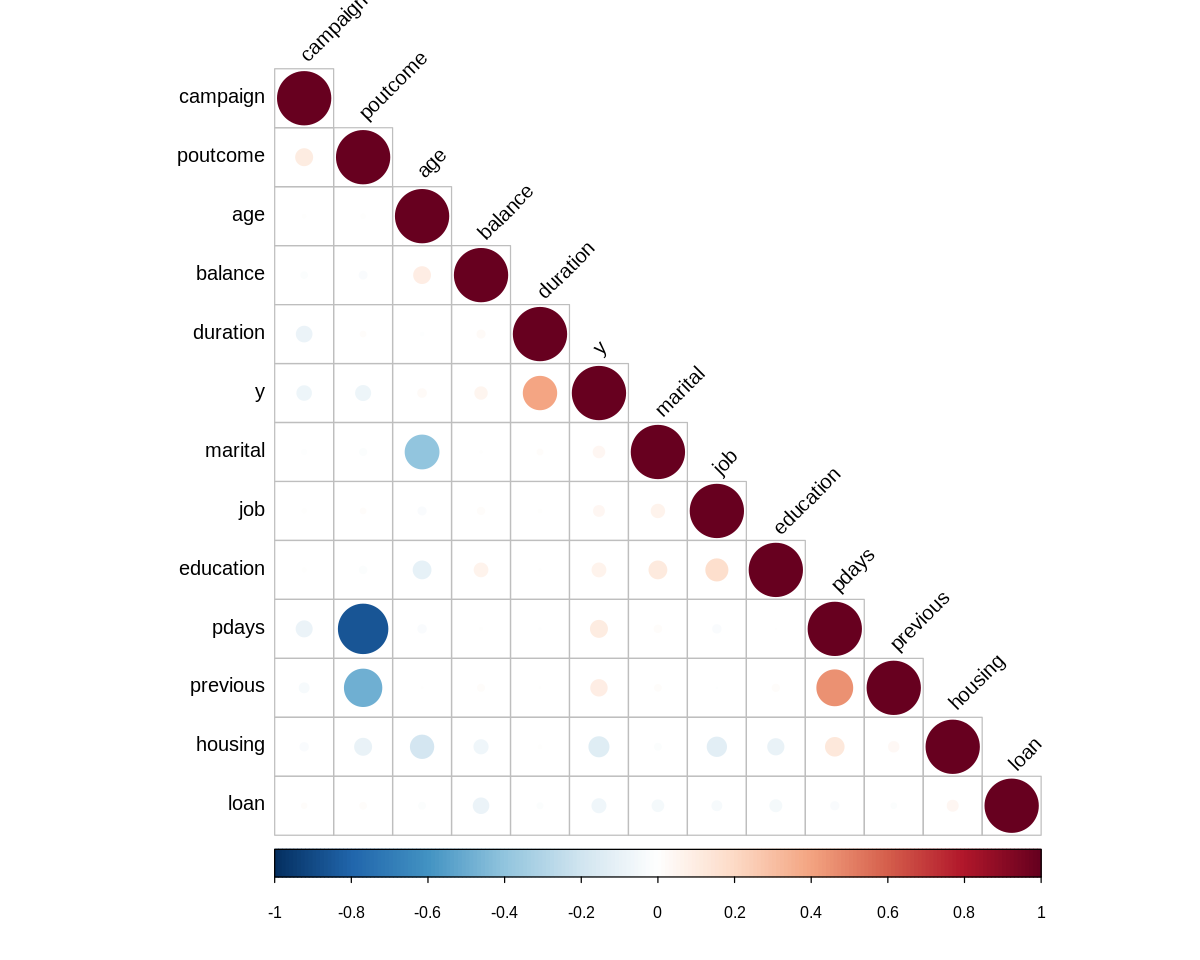

In [87]:
# print corelation table
rquery.cormat(bank_nums)
print("Viz. 1")

We can see from the correlation table (Viz. 1) that most variables seem to have little influence on our `y` value. The only variable with a significant impact on the outcome was `duration` which had a strong positive correlation of around 0.4.

To further test our correlation table results we test each variables influence on the outcome using knn classification.

#### Checking variable influence using KNN.

To do this we first create a specification for our knn classification model.

In [12]:
# create knn model
knn_spec = nearest_neighbor(weight_func = "rectangular") %>%
       set_engine("kknn") %>%
       set_mode("classification")

knn_spec

K-Nearest Neighbor Model Specification (classification)

Main Arguments:
  weight_func = rectangular

Computational engine: kknn 


Than we predict the accuracy of a model using all variables to get a baseline accuracy.

To do this we scale all our predictor as knn is sensitive to sacle and than create a workflow and compare the results of our training table model to our testing model which will tell us the accuracy of it.

In [13]:
bank_recipe_all <- recipe(y ~ ., data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())
bank_recipe_all

knn_fit_all <- workflow() %>%
    add_recipe(bank_recipe_all) %>%
    add_model(knn_spec) %>%
    fit(data = bank_train)
knn_fit_all

bank_test_predictions_all <- predict(knn_fit_all, bank_test) %>%
  bind_cols(bank_test)

all_pred = bank_test_predictions_all %>%
  metrics(truth = y, estimate = .pred_class)
all_pred

Data Recipe

Inputs:

      role #variables
   outcome          1
 predictor         12

Operations:

Scaling for all_predictors()
Centering for all_predictors()

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

● step_scale()
● step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = 5, kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1086437
Best kernel: rectangular
Best k: 5

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8918775
kap,binary,0.3674238


Here we see that we have a baseline accuracy of `0.8918775` (89.19%). We will compare this to the accuracy of different specific variables to see if they have a greater influence on the outcome.

Seeing that our best k from the previous fit was 5 we chose to stick with that for the rest of our KNN models.

In [14]:
knn_specification <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) %>%
  set_engine("kknn") %>%
  set_mode("classification")

Accuracy of `age` variable as a predictor:

In [15]:
bank_recipe_age <- recipe(y ~ age, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_age <- workflow() %>%
    add_recipe(bank_recipe_age) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

bank_test_predictions_age <- predict(knn_fit_age, bank_test) %>%
  bind_cols(bank_test)

age_pred = bank_test_predictions_age %>%
  metrics(truth = y, estimate = .pred_class)

age_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.88382587
kap,binary,0.05028407


Accuracy of `job` variable as a predictor:

In [16]:
bank_recipe_job <- recipe(y ~ job, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_job <- workflow() %>%
    add_recipe(bank_recipe_job) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

bank_test_predictions_job <- predict(knn_fit_job, bank_test) %>%
  bind_cols(bank_test)

job_pred = bank_test_predictions_job %>%
  metrics(truth = y, estimate = .pred_class)

job_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8830296
kap,binary,0.0000000


Accuracy of `marital` status variable as a predictor:

In [17]:
bank_recipe_marital <- recipe(y ~ marital, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_marital <- workflow() %>%
    add_recipe(bank_recipe_marital) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

bank_test_predictions_marital <- predict(knn_fit_marital, bank_test) %>%
  bind_cols(bank_test)

marital_pred = bank_test_predictions_marital %>%
  metrics(truth = y, estimate = .pred_class)
marital_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8830296
kap,binary,0.0000000


Accuracy of `education` variable as a predictor.

In [18]:
bank_recipe_education <- recipe(y ~ education, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_education <- workflow() %>%
    add_recipe(bank_recipe_education) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [19]:
bank_test_predictions_education <- predict(knn_fit_education, bank_test) %>%
 bind_cols(bank_test)

bank_test_predictions_education %>%
 metrics(truth = y, estimate = .pred_class)

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8830296
kap,binary,0.0000000


Accuracy of `balance` variable as a predictor:

In [20]:
bank_recipe_balance <- recipe(y ~ balance, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_balance <- workflow() %>%
    add_recipe(bank_recipe_balance) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [21]:
bank_test_predictions_balance <- predict(knn_fit_balance, bank_test) %>%
  bind_cols(bank_test)

balance_pred = bank_test_predictions_balance %>%
  metrics(truth = y, estimate = .pred_class)

balance_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.87895948
kap,binary,0.04182635


Accuracy of `housing` variable as a predictor:

In [22]:
bank_recipe_housing <- recipe(y ~ housing, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_housing <- workflow() %>%
    add_recipe(bank_recipe_housing) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [23]:
bank_test_predictions_housing <- predict(knn_fit_housing, bank_test) %>%
  bind_cols(bank_test)

housing_pred = bank_test_predictions_housing %>%
  metrics(truth = y, estimate = .pred_class)

housing_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8830296
kap,binary,0.0000000


Accuracy of `loan` variable as a predictor:

In [24]:
bank_recipe_loan <- recipe(y ~ loan, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_loan <- workflow() %>%
    add_recipe(bank_recipe_loan) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

In [25]:
bank_test_predictions_loan <- predict(knn_fit_loan, bank_test) %>%
  bind_cols(bank_test)

loan_pred = bank_test_predictions_loan %>%
  metrics(truth = y, estimate = .pred_class)

loan_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8830296
kap,binary,0.0000000


We see from these results that variables that held little influence on the outcome in the correlation table seem to have very similar accuracy to each other and the basline.

Now to test our results from the correlation table we inspect the accuracy of the `duration` variable.

In [26]:
bank_recipe_duration <- recipe(y ~ duration, data = bank_train) %>%
  step_scale(all_predictors()) %>%
  step_center(all_predictors())

knn_fit_duration <- workflow() %>%
    add_recipe(bank_recipe_duration) %>%
    add_model(knn_specification) %>%
    fit(data = bank_train)

bank_test_predictions_duration <- predict(knn_fit_duration, bank_test) %>%
  bind_cols(bank_test)

duration_pred = bank_test_predictions_duration %>%
  metrics(truth = y, estimate = .pred_class)
duration_pred

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8817908
kap,binary,0.1849427


Than we created a visualation of the model accuracy for different variables

[1] "Viz. 2"


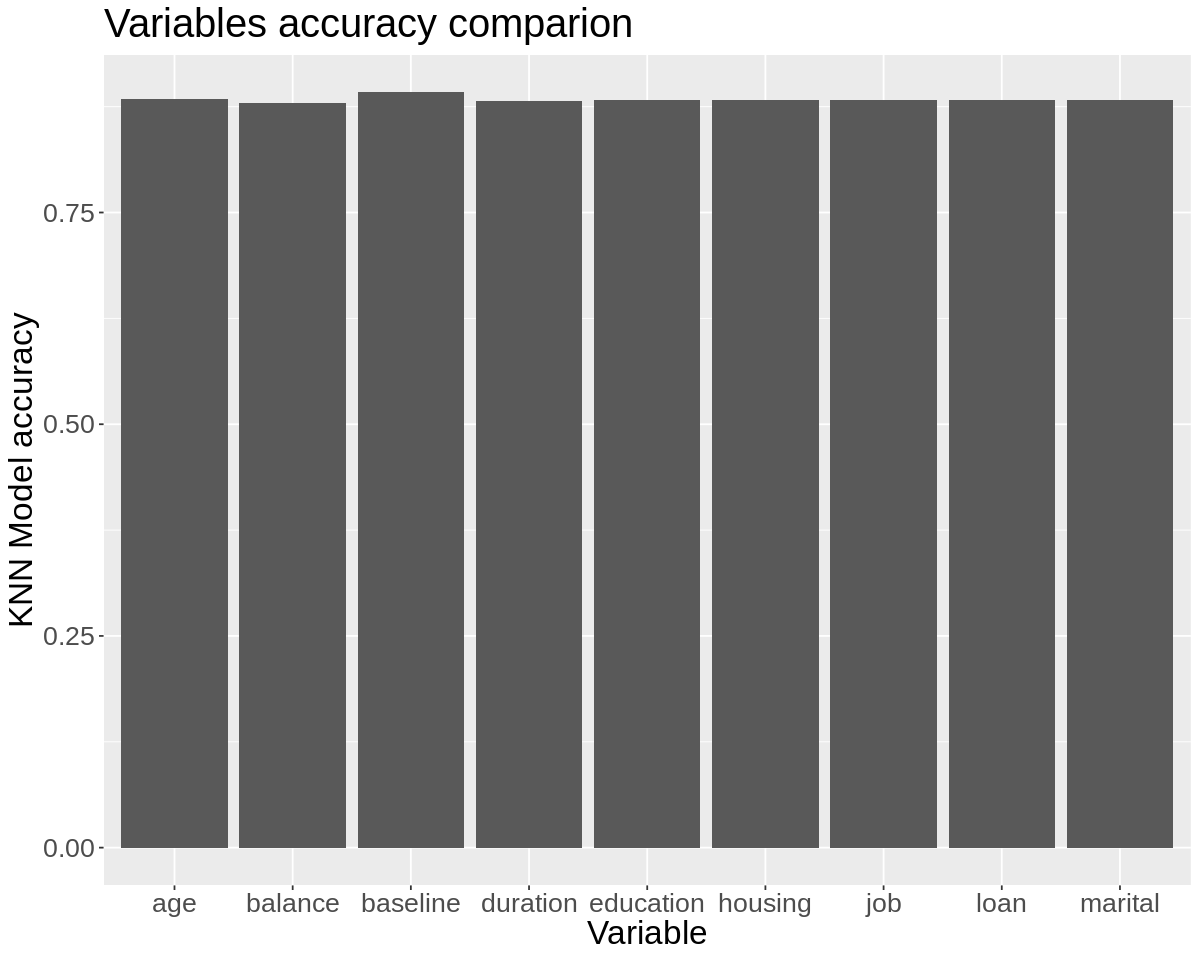

In [91]:
var_name <- c("baseline", "age", "job", "marital", "education", "balance", "housing", "loan", "duration")
accuracy <- c(0.8918775, 0.88382587, 0.8830296, 0.8830296, 0.8830296, 0.87895948, 0.8830296, 0.8830296, 0.8817908)
df <- data.frame(var_name, accuracy)

print("Viz. 2")

options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(df, aes(var_name, accuracy)) +
    geom_col() +
    theme(text = element_text(size = 20)) +
    xlab("Variable") +
    ylab("KNN Model accuracy") +
    ggtitle("Variables accuracy comparion")

Interestingly when observing viz. 2 the `duration` variable seems to have a similar accuracy to the rest of the irrelevant variables we tested. We believe this is because accuracy doesn't necessarily mean that the variable is a large influence and decided that this method of finding the most influential variable was not accurate enough.

Because of this we decided to do some further testing on our dataset. Using some more advanced methods we found online we tried to see if we could leverage more ML algorithms to find the most influential predictors. These aren't things we covered in class so our knowledge on them is limited but we thought it may provide some interesting insight and was worth trying.

To use these algorithms we first have to replace all the unknown values with `NA` so they don't affect our results. We also made sure to change some of our true/false yes/no type columns to 1 or 0 for faster processing.

In [27]:
bank_preped = mutate(bank_trimmed, across(where(is.character), ~na_if(., "unknown")))
bank_preped = mutate(bank_preped, pdays = na_if(pdays, -1))
bank_preped = mutate(bank_preped, y = as_factor(y))
bank_preped = mutate(bank_preped, housing = ifelse(housing == "yes", 1, 0))
bank_preped = mutate(bank_preped, loan = ifelse(loan == "yes", 1, 0))

slice(bank_preped, 1:10)

age,job,marital,education,balance,housing,loan,duration,campaign,pdays,previous,poutcome,y
<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<fct>
58,management,married,tertiary,2143,1,0,261,1,NA,0,NA,no
44,technician,single,secondary,29,1,0,151,1,NA,0,NA,no
33,entrepreneur,married,secondary,2,1,1,76,1,NA,0,NA,no
47,blue-collar,married,NA,1506,1,0,92,1,NA,0,NA,no
33,NA,single,NA,1,0,0,198,1,NA,0,NA,no
35,management,married,tertiary,231,1,0,139,1,NA,0,NA,no
28,management,single,tertiary,447,1,1,217,1,NA,0,NA,no
42,entrepreneur,divorced,tertiary,2,1,0,380,1,NA,0,NA,no
58,retired,married,primary,121,1,0,50,1,NA,0,NA,no


First we tried a logistic regression model. We were unable to get it to work with all variables so there are a couple omitted. Furthermore running this code against the entire dataframe crashed my R kernel and jupyter for around 30 minutes so here we only use a sample of the table (10000 of ~35000 total rows).

In [46]:
summary(glm(I(y == "yes") ~ age + job + marital + education + balance + housing + loan + duration + campaign + previous, data = slice(bank_preped, 1:10000), family="binomial"))


Call:
glm(formula = I(y == "yes") ~ age + job + marital + education + 
    balance + housing + loan + duration + campaign + previous, 
    family = "binomial", data = slice(bank_preped, 1:10000))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-4.8257  -0.1762  -0.1251  -0.0937   3.1890  

Coefficients: (1 not defined because of singularities)
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)        -4.714e+00  5.486e-01  -8.593  < 2e-16 ***
age                -3.981e-03  8.796e-03  -0.453   0.6509    
jobblue-collar     -6.514e-02  2.395e-01  -0.272   0.7857    
jobentrepreneur    -3.900e-02  4.609e-01  -0.085   0.9326    
jobhousemaid       -2.672e-01  6.162e-01  -0.434   0.6646    
jobmanagement      -1.924e-01  3.200e-01  -0.601   0.5476    
jobretired         -2.506e-01  4.832e-01  -0.519   0.6040    
jobself-employed    1.595e-01  4.164e-01   0.383   0.7017    
jobservices        -3.302e-01  2.892e-01  -1.142   0.2534    
jobstudent   

Reading the results from the logistic regression model may seem daunting but in essense variables with a lower P values denoted by the `Pr(>|z|)` column are higher probablility to be near the coefficient denoted in the `value` column. The results helpfully indicate significance with codes where `***` is most significant `.` is least signicant and none (` `) is insignificant.

This tells us that the most influential variable is `duration` followed by `marital`. The `duration` variable has a positive correlation meaning the longer the duration the more likely they are to have subscribed to a term deposit. This result aligns with the correlation table we created and inspected earlier. `marital` seems to indicate that those that are married are far less likely to have subscribed to a term deposit. This doesn't show on our correlation table from earlier most likely due to the way data had to be processed before applying that algorithm as correlation tables aren't meant to be used with classification information.

We also used random forest testing to test the quantatative variables in the dataset. We had the same issue as before where running it against the entire dataframe crashed jupyter and R so we again used a sample of the data.

In [94]:
rf <- randomForest(y ~ age + balance + duration, data = slice(bank_preped, 1:20000))
importance = rf$importance
importance

,MeanDecreaseGini
age,215.4429
balance,375.1904
duration,994.9314


[1] "Viz. 3"


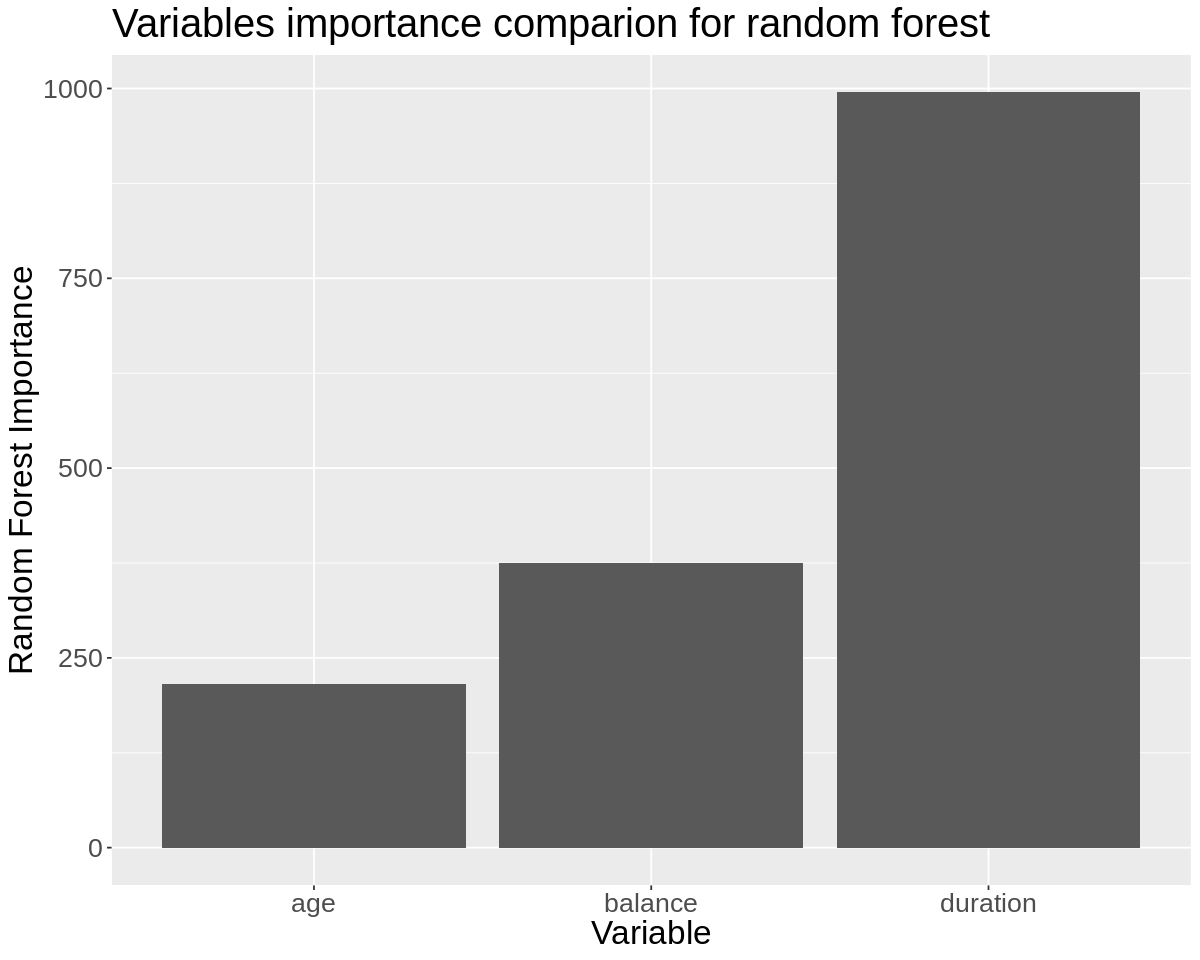

In [107]:
var_name_forest <- c("age", "balance", "duration")
mean_gini <- c(215.4429, 375.1904, 994.9314)
df_forest <- data.frame(var_name_forest, mean_gini)

print("Viz. 3")

options(repr.plot.width = 10, repr.plot.height = 8)
ggplot(df_forest, aes(var_name_forest, mean_gini)) +
    geom_col() +
    theme(text = element_text(size = 20)) +
    xlab("Variable") +
    ylab("Random Forest Importance") +
    ggtitle("Variables importance comparion for random forest")

The results from viz. 3 (random forest) show that `duration` has a far greater impact on the outcome compared to `balance` and `age` which echos our previous results.

## Conclusion



From creating and using different specifications, recipes, visualizations, and algorithms we found that only duration and marriage truly predicted better than the other predictors. All other variables yielded to approximately the same accuracy, and as our correlation table suggests, none of the variables seemed to correlate to `y` significantly. For all variables apart from duration and marriage, although the variables have a slight change in accuracy in our prediction, the accuracy is not sufficient enough to stand out.

This is not fully what we expected as we thought that one’s balance would be a clear indicator of subscribing to a term deposit. It turned out that one’s balance had about the same accuracy in predicting our model as all the other predictor variables apart from duration and marriage.
Although we did not come to the conclusion expected, seeing that subscribing to a term deposit has no correlation with one’s balance, it may raise the question on what type of saving/investing do have a correlation with balance. If the “rich” people are not investing in term deposits that what are they investing in and what are the advantages and disadvantages of that? We can also ask "Why does duration have an effect on subscribing to a term deposit, and is it a cause-and-effect relationship?" This leads to asking ourselves, "Is there a third variable that links duration and subscribing or does one cause the other?"

The results of this project could indicate to banks that when marketing term deposits there is no need to market towards someone with high/low balance and they should focus on the duration factor. These results could possibly suggest that subscribing to term deposits may not be a complicated procedure as all the predictor variables have a very wide range. People of many ages, different balances, etc., have all subscribed to term deposits and thus it may be an easy way to invest for anyone no matter your age, job, balance, etc. This also suggest that they are risk free, which we later confirmed form the site https://www.islandsavings.ca/simple-advice/investing-advice/term-deposits-guide

## References

UCI Machine Learning Repository: Bank Marketing Data Set. (n.d.). https://archive.ics.uci.edu/ml/datasets/Bank+Marketing. 

Carroll, R. J., & Pederson, S. (1993). On robustness in the logistic regression model. *Journal of the Royal Statistical Society: Series B (Methodological), 55*(3), 693-706. doi:10.1111/j.2517-6161.1993.tb01934.x

Svetnik, V., Liaw, A., Tong, C., Culberson, J. C., Sheridan, R. P., & Feuston, B. P. (2003). Random forest: A classification and regression tool for Compound classification and QSAR Modeling. *Journal of Chemical Information and Computer Sciences, 43*(6), 1947-1958. doi:10.1021/ci034160g

Chen, J. (2020, September 16). *Term Deposit Definition*. Investopedia. https://www.investopedia.com/terms/t/termdeposit.asp. 

Savings, C. C. (2020, October 20). *All about term deposits.* The Help Hub. https://blog.coastcapitalsavings.com/managing-your-money/all-about-term-deposits/. 

*Term Deposits in 2021: A Complete Guide.* Term Deposits in 2021: A Complete Guide | Island Savings. (n.d.). https://www.islandsavings.ca/simple-advice/investing-advice/term-deposits-guide.